In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
num_workers = 4

batch_size = 128
default_learning_rate = 0.1

In [3]:
from torch import nn
import numpy as np
import torch
import vgg
import os
import sys
import random
from tqdm import tqdm as tqdm
from util import get_number_of_parameters, get_accuracy, set_random_seeds
from IPython import display

In [4]:
# add our package dir to path
module_path = os.path.dirname(os.getcwd())
sys.path.append(module_path)

home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

In [5]:
device_id = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(device_id)

device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device_id))

cuda:0
NVIDIA GeForce RTX 3090 Ti


In [6]:
from data import get_cifar_loader

In [7]:
train_loader = get_cifar_loader(batch_size=batch_size, train=True)
val_loader = get_cifar_loader(batch_size=batch_size, train=False)

Files already downloaded and verified
Files already downloaded and verified


tensor([[[-0.6157, -0.5922, -0.5843,  ...,  0.3020,  0.3020,  0.3176],
         [-0.5373, -0.5216, -0.4745,  ...,  0.3490,  0.3020,  0.2157],
         [-0.4353, -0.4196, -0.3961,  ...,  0.3882,  0.4431,  0.4039],
         ...,
         [-0.1529, -0.1216, -0.1059,  ...,  0.0431,  0.1686,  0.0745],
         [-0.1451, -0.1137, -0.0824,  ..., -0.0431,  0.0353, -0.0588],
         [-0.1451, -0.1137, -0.0902,  ..., -0.1059, -0.1216, -0.2078]],

        [[-0.6941, -0.6784, -0.6706,  ...,  0.1686,  0.1843,  0.1922],
         [-0.6392, -0.6235, -0.5922,  ...,  0.2000,  0.1451,  0.0745],
         [-0.5529, -0.5529, -0.5216,  ...,  0.2235,  0.2627,  0.2314],
         ...,
         [-0.2863, -0.2627, -0.2471,  ..., -0.1216, -0.0039, -0.0902],
         [-0.2784, -0.2471, -0.2314,  ..., -0.2000, -0.1137, -0.1843],
         [-0.2784, -0.2471, -0.2314,  ..., -0.2314, -0.2471, -0.3020]],

        [[-0.7255, -0.7176, -0.7098,  ...,  0.0745,  0.0980,  0.0980],
         [-0.6941, -0.6784, -0.6392,  ...,  0

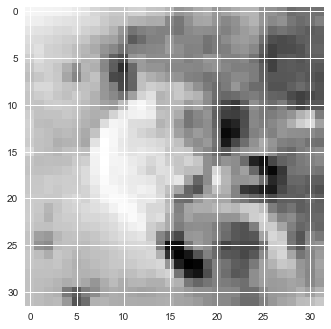

In [8]:
for X,y in train_loader:
    print(X[0])
    print(y[0])
    print(X[0].shape)
    label = X
    target = y
    plt.imshow(np.array(X[0,0,:,:]))
    print(X[0].max())
    print(X[0].min())
    break

In [10]:
model = vgg.VGG_A()
get_number_of_parameters(model)

9750922

In [11]:
model = vgg.VGG_A_Batch()
get_number_of_parameters(model)

9758474

In [12]:
model = vgg.VGG_A_Layer(label[0].shape)
get_number_of_parameters(model)

10056074

In [15]:
def train(model,
          optimizer,
          criterion,
          train_loader,
          val_loader,
          scheduler=None,
          epochs_n=100,
          best_model_path=None):

    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = len(train_loader)
    losses_list = []
    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:
            scheduler.step()
        model.train()
        loss_list = []
        learning_curve[epoch] = 0
        for data in train_loader:

            #print(data)

            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            #print(loss.item())
            loss_list.append(loss.item())
            learning_curve[epoch] += loss.item()
            loss.backward()
            optimizer.step()
        losses_list.append(loss_list)
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)

        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if best_model_path:
                torch.save(model.state_dict(), best_model_path)

        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()
    return losses_list

In [16]:
epo = 20

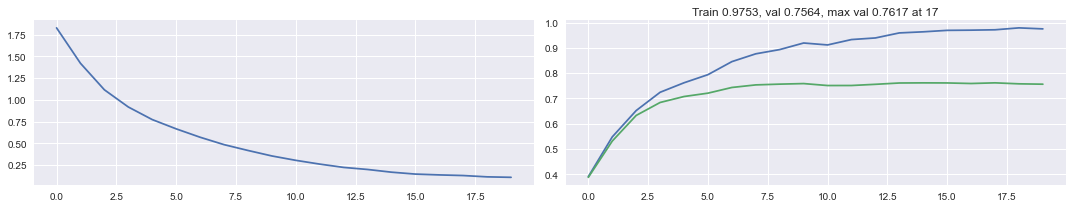

100%|██████████| 20/20 [12:58<00:00, 38.93s/epoch]


In [17]:
os.path.join(os.getcwd(), 'best_vgg_1.pt') #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A()
lr = 0.001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

loss_01 = train(model,
                optimizer,
                criterion,
                train_loader,
                val_loader,
                epochs_n=epo)

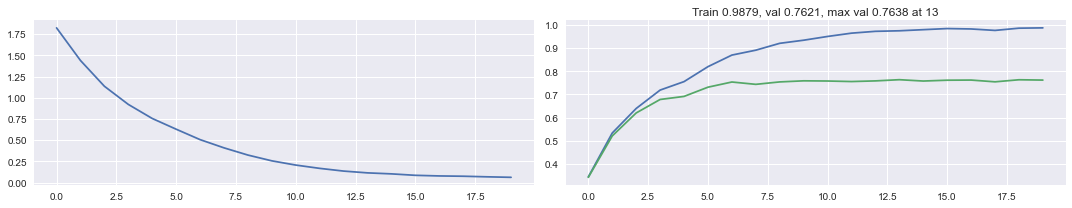

100%|██████████| 20/20 [13:14<00:00, 39.71s/epoch]


In [18]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A()
lr = 0.0005
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_005 = train(model,
                 optimizer,
                 criterion,
                 train_loader,
                 val_loader,
                 epochs_n=epo)

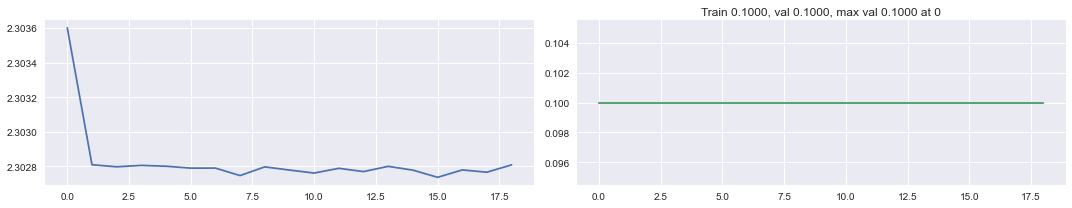

 95%|█████████▌| 19/20 [12:09<00:37, 37.49s/epoch]

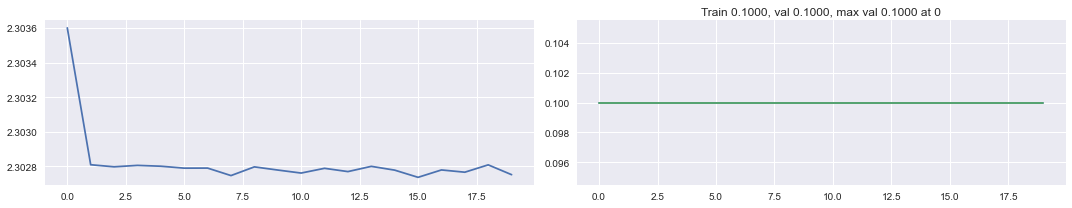

100%|██████████| 20/20 [12:47<00:00, 38.39s/epoch]


In [19]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A()
lr = 0.002
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_02 = train(model,
                optimizer,
                criterion,
                train_loader,
                val_loader,
                epochs_n=epo)

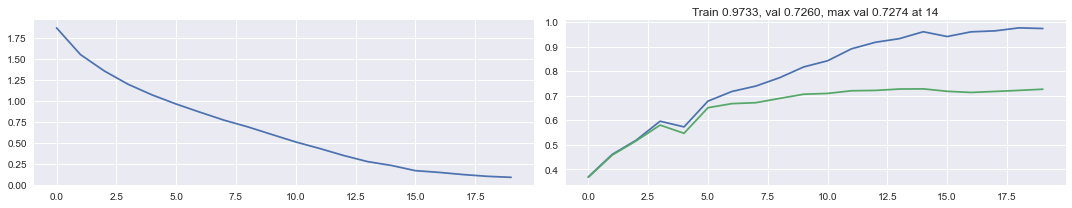

100%|██████████| 20/20 [12:50<00:00, 38.53s/epoch]


In [20]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A()
lr = 0.0001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)


loss_001 = train(model,
                 optimizer,
                 criterion,
                 train_loader,
                 val_loader,
                 epochs_n=epo)


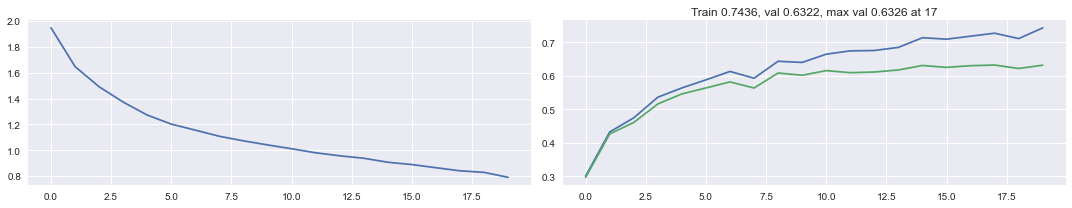

100%|██████████| 20/20 [15:27<00:00, 46.38s/epoch]


In [21]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A()
lr = 0.003
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

loss_03 = train(model,
                optimizer,
                criterion,
                train_loader,
                val_loader,
                epochs_n=epo)

In [22]:
#import itertools
loss_01 = np.array(loss_01).flatten()
loss_03 = np.array(loss_03).flatten()
loss_005 = np.array(loss_005).flatten()
loss_001 = np.array(loss_001).flatten()
min_curve = []
max_curve = []
for i in range(len(loss_01)):
    min_curve.append(np.min([loss_01[i], loss_03[i], loss_005[i], loss_001[i]]))
    max_curve.append(np.max([loss_01[i], loss_03[i], loss_005[i], loss_001[i]]))

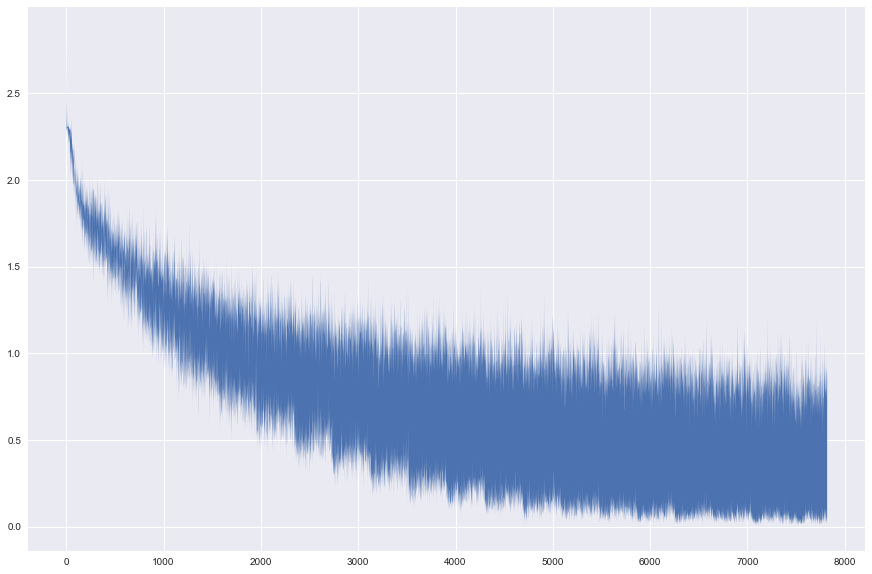

In [23]:
plt.figure(figsize=(15, 10))
plt.fill_between(range(len(min_curve)), min_curve, max_curve)

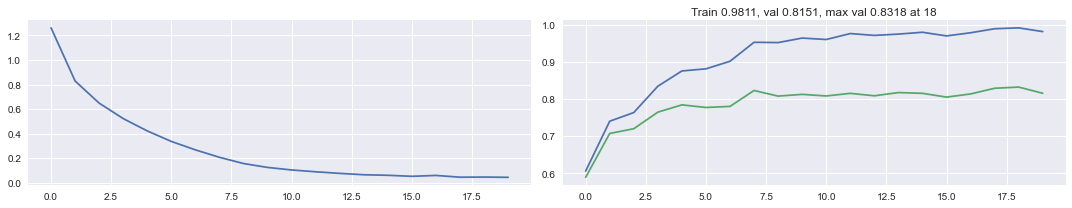

100%|██████████| 20/20 [15:02<00:00, 45.12s/epoch]


In [24]:
plt.fill_between(range(len(min_curve)), min_curve, max_curve)
os.path.join(os.getcwd(), 'best_vgg_1.pt')  #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Batch()
lr = 0.001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_batch_01 = train(model,
                      optimizer,
                      criterion,
                      train_loader,
                      val_loader,
                      epochs_n=epo)

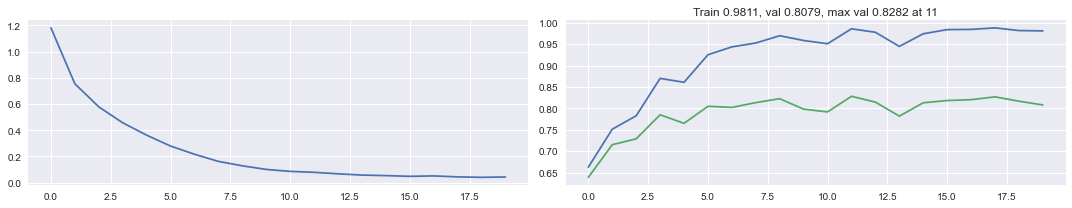

100%|██████████| 20/20 [13:08<00:00, 39.43s/epoch]


In [25]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Batch()
lr = 0.0005
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_batch_005 = train(model,
                       optimizer,
                       criterion,
                       train_loader,
                       val_loader,
                       epochs_n=epo)


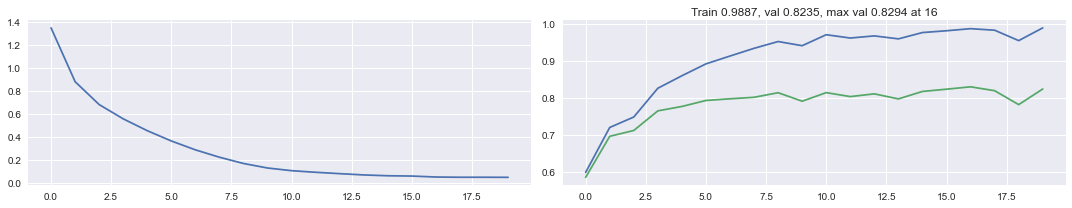

100%|██████████| 20/20 [13:35<00:00, 40.76s/epoch]


In [26]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Batch()
lr = 0.002
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_batch_02 = train(model,
                      optimizer,
                      criterion,
                      train_loader,
                      val_loader,
                      epochs_n=epo)


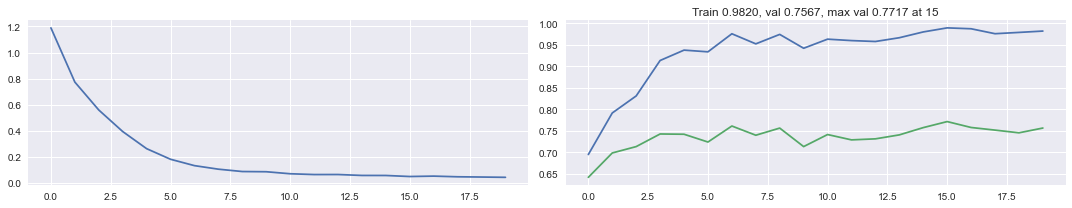

100%|██████████| 20/20 [13:11<00:00, 39.60s/epoch]


In [27]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Batch()
lr = 0.0001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_batch_001 = train(model,
                       optimizer,
                       criterion,
                       train_loader,
                       val_loader,
                       epochs_n=epo)


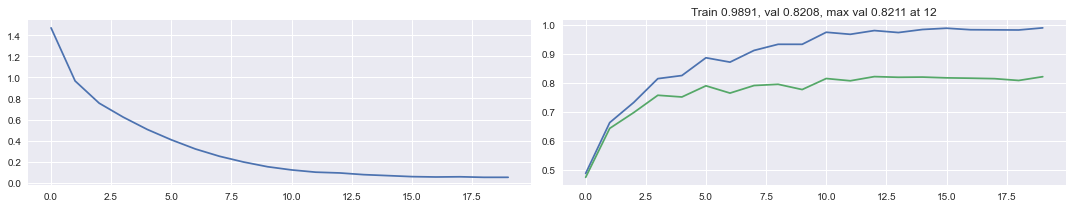

100%|██████████| 20/20 [13:18<00:00, 39.94s/epoch]


In [28]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Batch()
lr = 0.003
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_batch_03 = train(model,
                      optimizer,
                      criterion,
                      train_loader,
                      val_loader,
                      epochs_n=epo)

In [29]:
loss_batch_01 = np.array(loss_batch_01).flatten()
loss_batch_03 = np.array(loss_batch_03).flatten()
loss_batch_005 = np.array(loss_batch_005).flatten()
loss_batch_001 = np.array(loss_batch_001).flatten()
min_curve_batch = []
max_curve_batch = []
for i in range(len(loss_01)):
    min_curve_batch.append(np.min([loss_batch_01[i], loss_batch_03[i], loss_batch_005[i], loss_batch_001[i]]))
    max_curve_batch.append(np.max([loss_batch_01[i], loss_batch_03[i], loss_batch_005[i], loss_batch_001[i]]))

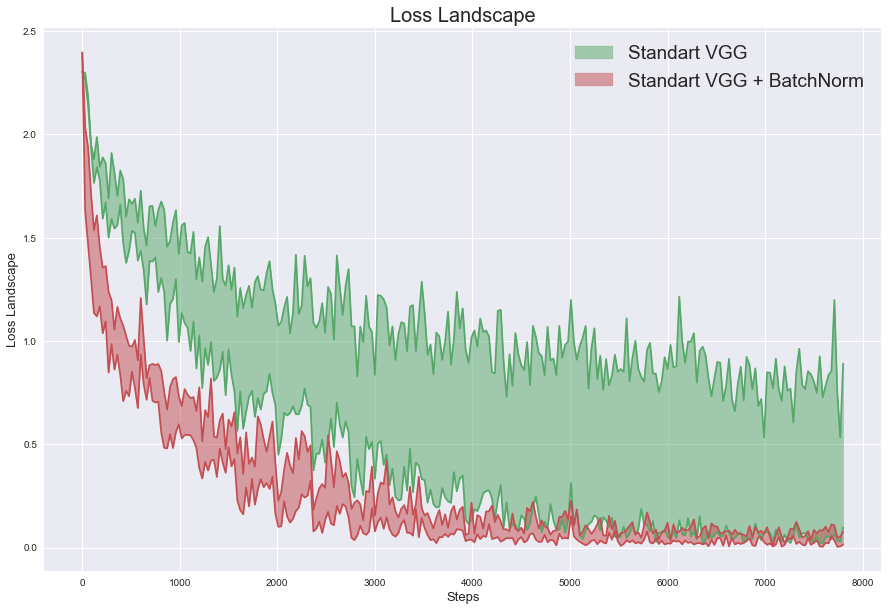

In [30]:
step = 30
steps = np.arange(0, len(min_curve), step)
plt.figure(figsize=(15, 10))
plt.fill_between(steps, min_curve[::step], max_curve[::step],
                 alpha=0.5, color='C1', label='Standard VGG')
plt.plot(steps, min_curve[::step], color='C1')
plt.plot(steps, max_curve[::step], color='C1')

plt.fill_between(steps, min_curve_batch[::step], max_curve_batch[::step],
                 alpha=0.5, color='C2', label='Standard VGG + BatchNorm')
plt.plot(steps, min_curve_batch[::step], color='C2')
plt.plot(steps, max_curve_batch[::step], color='C2')

plt.legend(fontsize=19)
plt.title('Loss Landscape', fontsize=20)
plt.ylabel('Loss Landscape', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig(os.path.join('loss_landscape.png'), dpi=500, quality=100)
plt.show()

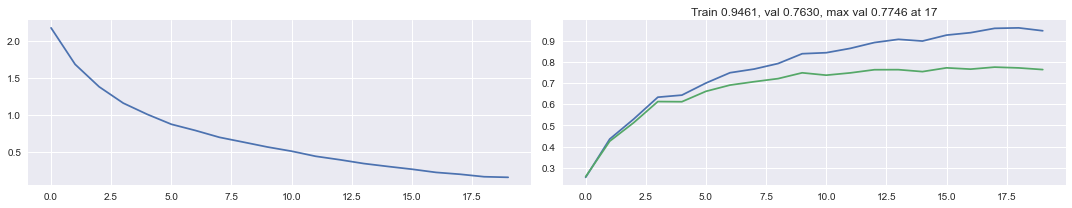

100%|██████████| 20/20 [12:41<00:00, 38.07s/epoch]


In [31]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Layer(label[0].shape)
lr = 0.001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_layer_01 = train(model,
                      optimizer,
                      criterion,
                      train_loader,
                      val_loader,
                      epochs_n=epo)

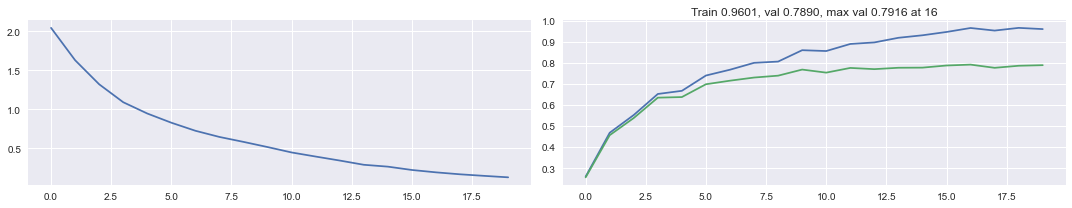

100%|██████████| 20/20 [12:47<00:00, 38.36s/epoch]


In [32]:
plt.show()
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Layer(label[0].shape)
lr = 0.0005
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_layer_005 = train(model,
                      optimizer,
                      criterion,
                      train_loader,
                      val_loader,
                      epochs_n=epo)

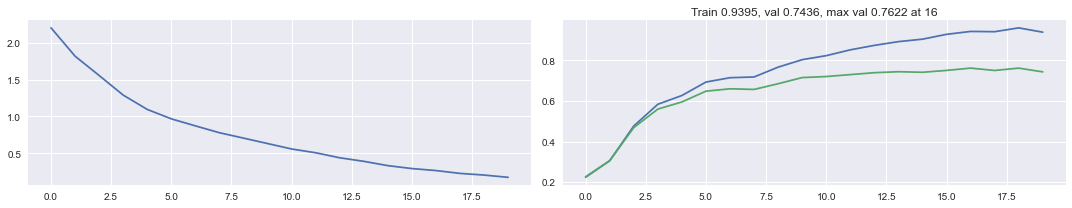

100%|██████████| 20/20 [13:19<00:00, 40.00s/epoch]


In [33]:
plt.show()
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Layer(label[0].shape)
lr = 0.002
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_layer_02 = train(model,
                       optimizer,
                       criterion,
                       train_loader,
                       val_loader,
                       epochs_n=epo)

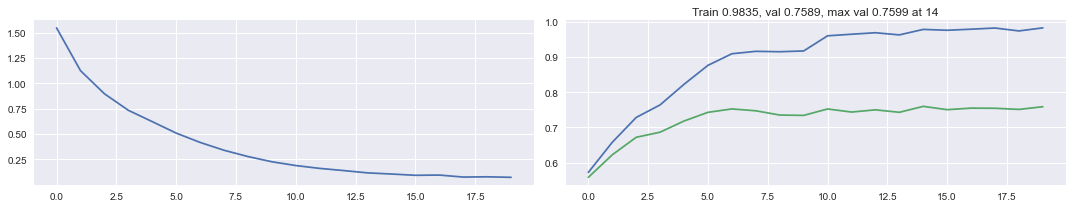

100%|██████████| 20/20 [12:19<00:00, 37.00s/epoch]


In [34]:
plt.show()
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Layer(label[0].shape)
lr = 0.0001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_layer_001 = train(model,
                       optimizer,
                       criterion,
                       train_loader,
                       val_loader,
                       epochs_n=epo)

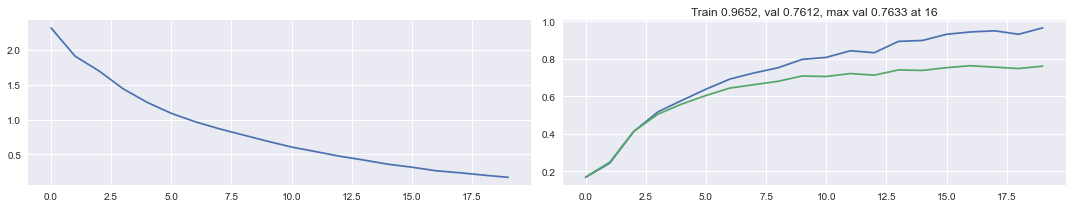

100%|██████████| 20/20 [15:12<00:00, 45.62s/epoch]


In [35]:
plt.show()
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Layer(label[0].shape)
lr = 0.003
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_layer_03 = train(model,
                      optimizer,
                      criterion,
                      train_loader,
                      val_loader,
                      epochs_n=epo)

In [36]:
loss_layer_01 = np.array(loss_layer_01).flatten()
loss_layer_03 = np.array(loss_layer_03).flatten()
loss_layer_005 = np.array(loss_layer_005).flatten()
loss_layer_001 = np.array(loss_layer_001).flatten()
min_curve_layer = []
max_curve_layer = []
for i in range(len(loss_01)):
    min_curve_layer.append(np.min([loss_layer_01[i], loss_layer_03[i], loss_layer_005[i], loss_layer_001[i]]))
    max_curve_layer.append(np.max([loss_layer_01[i], loss_layer_03[i], loss_layer_005[i], loss_layer_001[i]]))

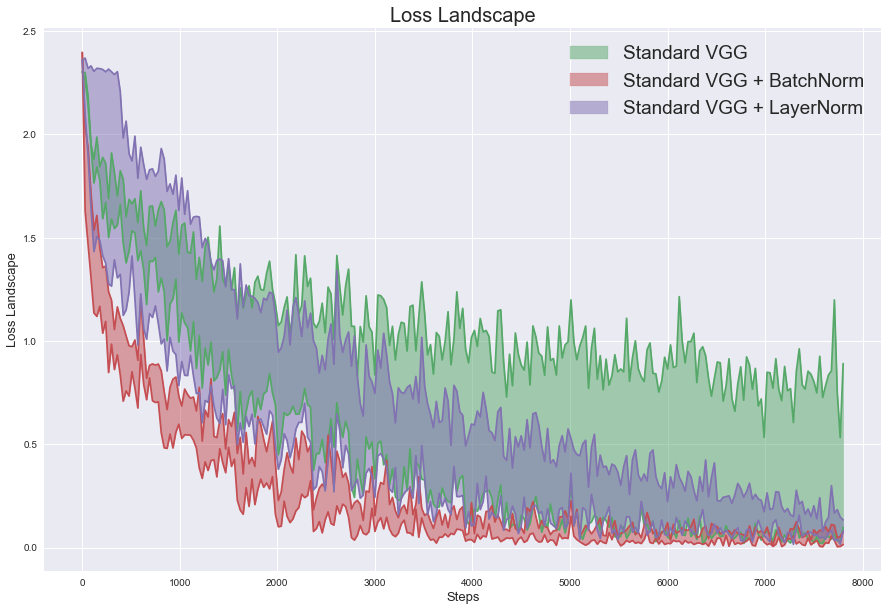

In [40]:
step = 30
steps = np.arange(0, len(min_curve), step)
plt.figure(figsize=(15, 10))
plt.fill_between(steps, min_curve[::step], max_curve[::step],
                 alpha=0.5, color='C1', label='Standard VGG')
plt.plot(steps, min_curve[::step], color='C1')
plt.plot(steps, max_curve[::step], color='C1')

plt.fill_between(steps, min_curve_batch[::step], max_curve_batch[::step],
                 alpha=0.5, color='C2', label='Standard VGG + BatchNorm')
plt.plot(steps, min_curve_batch[::step], color='C2')
plt.plot(steps, max_curve_batch[::step], color='C2')

plt.fill_between(steps, min_curve_layer[::step], max_curve_layer[::step],
                 alpha=0.5, color='C3', label='Standard VGG + LayerNorm')
plt.plot(steps, min_curve_layer[::step], color='C3')
plt.plot(steps, max_curve_layer[::step], color='C3')

plt.legend(fontsize=19)
plt.title('Loss Landscape', fontsize=20)
plt.ylabel('Loss Landscape', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig(os.path.join('loss_landscape.png'), dpi=500, quality=100)
plt.show()